In [ ]:
!pip install langgraph langchain langchain_openai langchain_core chromadb langchain_community

# Simple basic parallel workflow

In [ ]:
from langgraph.graph import StateGraph , END , START
from typing import TypedDict


In [ ]:
class BatsManStats (TypedDict):
  runs : int
  balls : int
  fours : int
  sixes : int
  strikeRate : float
  boundaryPerball : float
  boundary_percent : float
  summary : str

In [ ]:
graph = StateGraph(BatsManStats)

In [ ]:
def calculate_sr (state : BatsManStats)  :
  sr = (state['runs']/state['balls'])* 100
  return {'strikeRate':sr}

In [ ]:
def calculate_bpb (state : BatsManStats) :
  bpb  = state['balls'] / (state['fours'] + state['sixes'])

  return {'boundaryPerball' : bpb}

In [ ]:
def calulate_boundaryPercent (state : BatsManStats) :
  boundary_percent = (state['fours'] * 4 + state['sixes'] * 6) / (state['runs'] * 100)

  return {'boundary_percent' : boundary_percent}


In [ ]:
def calculate_summary (state : BatsManStats) :
  summary = f"""
  strike-rate {state['strikeRate']} \n
  Balls per boundary {state['boundaryPerball']} \n
  Boundary Percentage {state['boundary_percent']} \n

  """
  return {'summary' : summary}

In [ ]:
graph.add_node('calculate_sr',calculate_sr)
graph.add_node('calculate_bpb',calculate_bpb)
graph.add_node('calulate_boundaryPercent',calulate_boundaryPercent)
graph.add_node('calculate_summary',calculate_summary)

graph.add_edge(START,'calculate_sr')
graph.add_edge(START,'calculate_bpb')
graph.add_edge(START,'calulate_boundaryPercent')

graph.add_edge('calculate_sr','calculate_summary')
graph.add_edge('calculate_bpb','calculate_summary')
graph.add_edge('calulate_boundaryPercent','calculate_summary')

graph.add_edge ('calculate_summary' , END)

In [ ]:
workflow = graph.compile()

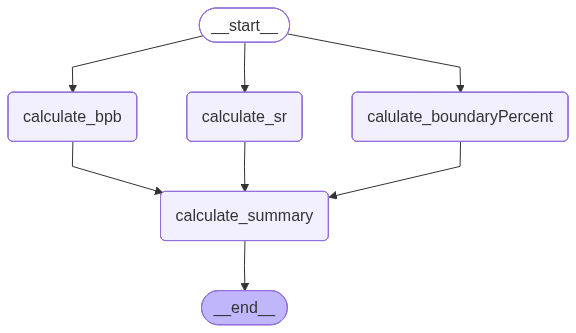

In [ ]:

from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [ ]:
final_state = workflow.invoke({'runs':200 , 'balls': 180 , 'fours' : 13 ,  'sixes' : 8})

In [ ]:
final_state

{'runs': 200,
 'balls': 180,
 'fours': 13,
 'sixes': 8,
 'strikeRate': 111.11111111111111,
 'boundaryPerball': 8.571428571428571,
 'boundary_percent': 0.005,
 'summary': '\n  strike-rate 111.11111111111111 \n\n  Balls per boundary 8.571428571428571 \n\n  Boundary Percentage 0.005 \n\n  \n  '}

# Wokflow with the LLM

In [ ]:
from langgraph.graph import StateGraph , END , START
from langchain_openai import ChatOpenAI
from typing import TypedDict
from pydantic import BaseModel , Field
import operator # for reducers

In [ ]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')


In [ ]:
llm_model = ChatOpenAI(model_name='gpt-3.5-turbo')

In [ ]:
class EvaluationSchema (BaseModel) :
  feedback : str = Field(description="Detail feedback for the essay")
  score : int = Field(description = "Score out of 10" , ge=0 , le=10)

In [ ]:
structured_model = llm_model.with_structured_output(EvaluationSchema)

/usr/local/lib/python3.12/dist-packages/langchain_openai/chat_models/base.py:1927: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [ ]:
from typing_extensions import Annotated
class PrepState (TypedDict) :
  essay : str
  language_feedback : str
  analysis_feedback : str
  clarity_feedback : str
  overall_feedback : str
  individual_score : Annotated[list[int] , operator.add]
  avg_score : float

In [ ]:
graph = StateGraph(PrepState)

In [ ]:
def language_feedback (state : PrepState) :
   prompt = f'Evaluate the language quality of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
   output = structured_model.invoke(prompt)

   return {'language_feedback':output.feedback , 'individual_score': [output.score]}

In [ ]:
def analysis_feedback (state : PrepState) :
   prompt = f'Evaluate the depth of analysis of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
   output = structured_model.invoke(prompt)

   return {'analysis_feedback':output.feedback , 'individual_score': [output.score]}

In [ ]:
def clarity_feedback  (state : PrepState) :
   prompt = f'Evaluate the clarity of thought of the following essay and provide a feedback and assign a score out of 10 \n {state["essay"]}'
   output = structured_model.invoke(prompt)

   return {'clarity_feedback':output.feedback , 'individual_score': [output.score]}

In [ ]:
def overall_feedback (state : PrepState) :
  prompt = f'Based on the following feedbacks create a summarized feedback \n language feedback {state["language_feedback"]} \n analysis feedback {state["analysis_feedback"]} \n clarity feedback {state["clarity_feedback"]}'
  output = structured_model.invoke(prompt)

  # avg_score
  avg_score = sum(state['individual_score']) / len(state['individual_score'])

  return {'overall_feedback':output.feedback , 'avg_score' : avg_score }

In [ ]:
graph.add_node('language_feedback',language_feedback)
graph.add_node('analysis_feedback',analysis_feedback)
graph.add_node('clarity_feedback',clarity_feedback)
graph.add_node('overall_feedback',overall_feedback)

graph.add_edge(START,'language_feedback')
graph.add_edge(START,'analysis_feedback')
graph.add_edge(START,'clarity_feedback')

graph.add_edge('language_feedback','overall_feedback')
graph.add_edge('analysis_feedback','overall_feedback')
graph.add_edge('clarity_feedback','overall_feedback')

graph.add_edge ('overall_feedback' , END)

In [ ]:
workflow = graph.compile()

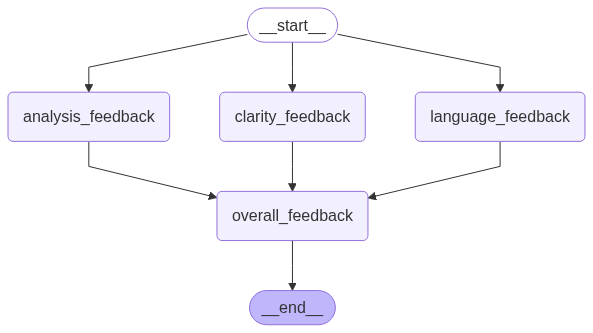

In [ ]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [ ]:
essay_1 = """
As the world transitions into an era defined by artificial intelligence (AI), Pakistan finds itself at a decisive crossroads — one that offers both the opportunity to leapfrog into the future of innovation and the risk of being left behind. The transformative power of AI holds immense potential for economic growth, social development, and governance, but realizing this promise will depend on how Pakistan addresses its unique challenges and leverages its existing strengths.
Pakistan’s foundation in AI is built upon a large pool of young talent, a growing base of STEM graduates, and a vibrant technology ecosystem. Each year, universities such as NUST, FAST, LUMS, and PIEAS produce thousands of computer science and engineering graduates. The country has also seen the rise of AI-focused startups in areas like fintech, healthtech, and e-commerce. Government initiatives, such as the establishment of the National Centre of Artificial Intelligence (NCAI) and the Digital Pakistan Vision, have signaled intent to integrate AI into critical domains including education, healthcare, agriculture, and public administration.
"""

In [ ]:
essay_2 = """
Pakistan is moving into the time of artificial intelligence (AI). This can give the country a chance to move forward or stay behind. AI has a lot of power to change things like economy, society, and government. But Pakistan can only get these benefits if it handles its problems and uses its good points.
Pakistan has many young people and many students graduating in STEM every year from universities like NUST, FAST, LUMS, and PIEAS. Some startups are also working in AI areas like finance, health, and online shopping. The government has also started some programs like the National Centre of Artificial Intelligence (NCAI) and Digital Pakistan Vision to use AI in areas like education, health, farming, and public offices.
"""

In [ ]:
workflow.invoke({'essay':essay_1})

{'essay': '\nAs the world transitions into an era defined by artificial intelligence (AI), Pakistan finds itself at a decisive crossroads — one that offers both the opportunity to leapfrog into the future of innovation and the risk of being left behind. The transformative power of AI holds immense potential for economic growth, social development, and governance, but realizing this promise will depend on how Pakistan addresses its unique challenges and leverages its existing strengths.\nPakistan’s foundation in AI is built upon a large pool of young talent, a growing base of STEM graduates, and a vibrant technology ecosystem. Each year, universities such as NUST, FAST, LUMS, and PIEAS produce thousands of computer science and engineering graduates. The country has also seen the rise of AI-focused startups in areas like fintech, healthtech, and e-commerce. Government initiatives, such as the establishment of the National Centre of Artificial Intelligence (NCAI) and the Digital Pakistan 

In [ ]:
workflow.invoke({'essay':essay_2})

{'essay': '\nPakistan is moving into the time of artificial intelligence (AI). This can give the country a chance to move forward or stay behind. AI has a lot of power to change things like economy, society, and government. But Pakistan can only get these benefits if it handles its problems and uses its good points.\nPakistan has many young people and many students graduating in STEM every year from universities like NUST, FAST, LUMS, and PIEAS. Some startups are also working in AI areas like finance, health, and online shopping. The government has also started some programs like the National Centre of Artificial Intelligence (NCAI) and Digital Pakistan Vision to use AI in areas like education, health, farming, and public offices.\n',
 'language_feedback': "The essay discusses the impact of artificial intelligence on Pakistan's future and highlights the country's potential in this field. It provides examples of universities, startups, and government initiatives. The language quality is

# RAG Pipeline in langgraph Sequential Chain

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import Chroma
from langchain_core.prompts import ChatPromptTemplate
from langchain.document_loaders import DirectoryLoader , TextLoader
from langchain_openai import ChatOpenAI , OpenAIEmbeddings
from langgraph.graph import StateGraph , END , START
from typing import TypedDict
from langchain_core.runnables import RunnablePassthrough

In [ ]:
import os
from google.colab import userdata
os.environ['OPENAI_API_KEY'] = userdata.get('OPENAI_API_KEY')

In [ ]:

llm_model = ChatOpenAI(model_name='gpt-3.5-turbo')
embedding_model = OpenAIEmbeddings()
parser = StrOutputParser()

In [ ]:
loader = DirectoryLoader('/content/data/', glob="**/*.txt", loader_cls=TextLoader)
document = loader.load()

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=200)
texts = text_splitter.split_documents(document)

In [ ]:
texts[0]

Document(metadata={'source': '/content/data/state_of_the_union.txt'}, page_content='Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and the Cabinet. Justices of the Supreme Court. My fellow Americans.  \n\nLast year COVID-19 kept us apart. This year we are finally together again. \n\nTonight, we meet as Democrats Republicans and Independents. But most importantly as Americans. \n\nWith a duty to one another to the American people to the Constitution. \n\nAnd with an unwavering resolve that freedom will always triumph over tyranny. \n\nSix days ago, Russia’s Vladimir Putin sought to shake the foundations of the free world thinking he could make it bend to his menacing ways. But he badly miscalculated. \n\nHe thought he could roll into Ukraine and the world would roll over. Instead he met a wall of strength he never imagined. \n\nHe met the Ukrainian people. \n\nFrom President Zelenskyy to every Ukrainian, their fearlessness, their courage, t

In [ ]:
doc_string = [doc.page_content for doc in texts]

In [ ]:
doc_string

['Madam Speaker, Madam Vice President, our First Lady and Second Gentleman. Members of Congress and the Cabinet. Justices of the Supreme Court. My fellow Americans.  \n\nLast year COVID-19 kept us apart. This year we are finally together again. \n\nTonight, we meet as Democrats Republicans and Independents. But most importantly as Americans. \n\nWith a duty to one another to the American people to the Constitution. \n\nAnd with an unwavering resolve that freedom will always triumph over tyranny. \n\nSix days ago, Russia’s Vladimir Putin sought to shake the foundations of the free world thinking he could make it bend to his menacing ways. But he badly miscalculated. \n\nHe thought he could roll into Ukraine and the world would roll over. Instead he met a wall of strength he never imagined. \n\nHe met the Ukrainian people. \n\nFrom President Zelenskyy to every Ukrainian, their fearlessness, their courage, their determination, inspires the world.',
 'He met the Ukrainian people. \n\nFrom 

In [ ]:
vectorstore = Chroma.from_documents(texts, embedding_model)
retriver = vectorstore.as_retriever(search_type = 'similarity' , search_kwargs={'k':3})

In [ ]:
query = "who is the speaker at the state of the unioun speech"
docs = retriver.get_relevant_documents(query)

In [ ]:
docs[0]

Document(metadata={'source': '/content/data/state_of_the_union.txt'}, page_content='The only nation that can be defined by a single word: possibilities. \n\nSo on this night, in our 245th year as a nation, I have come to report on the State of the Union. \n\nAnd my report is this: the State of the Union is strong—because you, the American people, are strong. \n\nWe are stronger today than we were a year ago. \n\nAnd we will be stronger a year from now than we are today. \n\nNow is our moment to meet and overcome the challenges of our time. \n\nAnd we will, as one people. \n\nOne America. \n\nThe United States of America. \n\nMay God bless you all. May God protect our troops.')

In [ ]:
docs[1]

Document(metadata={'source': '/content/data/state_of_the_union.txt'}, page_content='The only nation that can be defined by a single word: possibilities. \n\nSo on this night, in our 245th year as a nation, I have come to report on the State of the Union. \n\nAnd my report is this: the State of the Union is strong—because you, the American people, are strong. \n\nWe are stronger today than we were a year ago. \n\nAnd we will be stronger a year from now than we are today. \n\nNow is our moment to meet and overcome the challenges of our time. \n\nAnd we will, as one people. \n\nOne America. \n\nThe United States of America. \n\nMay God bless you all. May God protect our troops.')

In [ ]:
docs[2]

Document(metadata={'source': '/content/data/state_of_the_union.txt'}, page_content='And built the strongest, freest, and most prosperous nation the world has ever known. \n\nNow is the hour. \n\nOur moment of responsibility. \n\nOur test of resolve and conscience, of history itself. \n\nIt is in this moment that our character is formed. Our purpose is found. Our future is forged. \n\nWell I know this nation.  \n\nWe will meet the test. \n\nTo protect freedom and liberty, to expand fairness and opportunity. \n\nWe will save democracy. \n\nAs hard as these times have been, I am more optimistic about America today than I have been my whole life. \n\nBecause I see the future that is within our grasp. \n\nBecause I know there is simply nothing beyond our capacity. \n\nWe are the only nation on Earth that has always turned every crisis we have faced into an opportunity. \n\nThe only nation that can be defined by a single word: possibilities. \n\nSo on this night, in our 245th year as a natio

In [ ]:
class LLM_RAG_State (TypedDict):
  query : str
  message : str
  answer : str

In [ ]:
graph = StateGraph(LLM_RAG_State)

In [ ]:
def LLM_Response (state : LLM_RAG_State) :
  prompt = f"Your task is to provide the brief asnwer on the user query don't include to much reasoning. Following is the query {state['query']} "

  result = llm_model.invoke(prompt)

  state['answer'] = result
  return state

In [ ]:
def RAG_Response (state : LLM_RAG_State) :
  question = state['query']
  template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
  prompt = ChatPromptTemplate.from_template(template)

  retriever_chain = (
        {"context": retriver, "question": RunnablePassthrough()}
        | prompt
        | llm_model
        | parser
        )
  result  = retriever_chain.invoke(question)
  state['answer'] = result
  return state

In [ ]:
graph.add_node('LLM_Response',LLM_Response)
graph.add_node('RAG_Response',RAG_Response)

graph.add_edge(START,'LLM_Response')
graph.add_edge('LLM_Response','RAG_Response')

graph.add_edge('RAG_Response' , END)

In [ ]:
workflow = graph.compile()

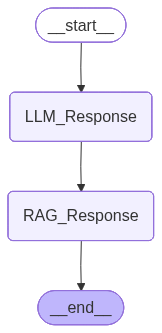

In [ ]:
from IPython.display import Image
Image(workflow.get_graph().draw_mermaid_png())

In [ ]:
inputs = {"query": "War conflict between Ukrain and Russia"}

In [ ]:
workflow.invoke({"query": "War conflict between Ukrain and Russia"})

{'query': 'War conflict between Ukrain and Russia',
 'answer': 'The document discusses the conflict between Ukraine and Russia, with the United States providing support to Ukraine in the form of military, economic, and humanitarian assistance. The document also states that American forces are not engaged in conflict with Russian forces in Ukraine but are mobilized to protect NATO allies in case Putin decides to continue moving west. The document emphasizes unity among nations and the support for Ukraine in the battle between democracy and autocracy.'}

In [ ]:
for output in workflow.stream(inputs):
    # stream() yields dictionaries with output keyed by node name
    for key, value in output.items():
        print(f"Output from node '{key}':")
        print("---")
        print(value)
    print("\n---\n")

Output from node 'LLM_Response':
---
{'query': 'War conflict between Ukrain and Russia', 'answer': AIMessage(content='The war conflict between Ukraine and Russia began in 2014.', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 13, 'prompt_tokens': 39, 'total_tokens': 52, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'id': 'chatcmpl-C95SWYpZN5vNm5QPydRFbwHP2mhur', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--62bc31f7-bef0-44dd-9667-a82187f343a2-0', usage_metadata={'input_tokens': 39, 'output_tokens': 13, 'total_tokens': 52, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})}

---

Output from node 'RAG_Response':
---
{'query': 'War

# Rag pipeline using conditional Chain

In [ ]:
from langchain_core.messages import BaseMessage
from typing import TypedDict, Annotated, Sequence
import operator
from pydantic import BaseModel , Field
from langchain.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser

In [ ]:
loader_2 = DirectoryLoader('/content/langchain', glob="**/*.txt", loader_cls=TextLoader)
document = loader_2.load()

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=800, chunk_overlap=200)
texts = text_splitter.split_documents(document)

In [ ]:
vectorstore = Chroma.from_documents(texts, embedding_model)
retriver = vectorstore.as_retriever(search_type = 'similarity' , search_kwargs={'k':3})

In [ ]:
query = "what is langchain"
docs = retriver.get_relevant_documents(query)

In [ ]:
for i , doc in enumerate(docs) :
  print(f"Document {i} \n")
  print(doc.page_content)

Document 0 

What it is:
LangChain is a framework that helps you build applications using Large Language Models (LLMs) like GPT, Gemini, Claude, Groq, etc.
Document 1 

LangChain

What it is:
LangChain is a framework that helps you build applications using Large Language Models (LLMs) like GPT, Gemini, Claude, Groq, etc.
Instead of just sending text to the LLM and getting plain text back, LangChain helps you connect the LLM with tools, memory, structured outputs, and workflows.

Key Features:

Chains: You can connect multiple steps together (e.g., ask LLM → search the web → summarize the result).
Document 2 

LangChain


In [ ]:
class TopicSelectionParser(BaseModel) :
  topic : str = Field(description="Selected topic")
  Reasoning: str = Field(description='Reasoning behind topic selection')

In [ ]:
str_output = llm_model.with_structured_output(TopicSelectionParser)

/usr/local/lib/python3.12/dist-packages/langchain_openai/chat_models/base.py:1927: UserWarning: Cannot use method='json_schema' with model gpt-3.5-turbo since it doesn't support OpenAI's Structured Output API. You can see supported models here: https://platform.openai.com/docs/guides/structured-outputs#supported-models. To fix this warning, set `method='function_calling'. Overriding to method='function_calling'.
  warnings.warn(


In [ ]:
str_output.invoke("what is the llm in the langchain")

TopicSelectionParser(topic='Low-Level Virtual Machine (LLVM) in Langchain', Reasoning='User asked for information about LLVM in Langchain')

In [ ]:
class LLM_OR_RAG (TypedDict):
  query : str
  answer : str
  message : Annotated[Sequence[BaseMessage] , operator.add]

In [ ]:
parser = StrOutputParser()

In [ ]:
def topic_chose (state : LLM_OR_RAG) :
  question = state['message'][-1]
  print(question)
  template="""
    Your task is to classify the given user query into one of the following categories: [Langchain, Langsmith, langgraph, Not Related].
    Only respond with the category name and nothing else.

    User query: {question}
    """
  prompt = PromptTemplate(
      template=template,
      input_variables=["question"],

  )
  chain = prompt | llm_model | parser
  response = chain.invoke({'question':question})
  print(response)
  return {"query": question ,'message' : [response]}

In [ ]:
def condition_trigger (state : LLM_OR_RAG) :
  last_message =  state['message'][-1]

  print(last_message)

  if any(x in last_message for x in ["Langchain", "Langsmith", "Langgraph"]):
      return "RAG Call"
  else:
      return "LLM Call"


In [ ]:
def LLM_Response (state : LLM_OR_RAG) :
  question = state["query"]
  prompt = f"Your task is to provide the  asnwer on the user query. Following is the query {question} "

  result = llm_model.invoke(prompt)

  return {'answer' : result.content }

In [ ]:
def RAG_Response (state: LLM_OR_RAG) :
  question = state['query']
  template = """Answer the question based only on the following context:
    {context}

    Question: {question}
    """
  prompt = ChatPromptTemplate.from_template(template)

  retriever_chain = (
        {"context": retriver, "question": RunnablePassthrough()}
        | prompt
        | llm_model
        | parser
        )
  result  = retriever_chain.invoke(question)
  return {"answer": result}

In [ ]:
workflow5 = StateGraph(LLM_OR_RAG)

In [ ]:
workflow5.add_node("agent", topic_chose)

workflow5.add_node("RAG", RAG_Response)

workflow5.add_node("LLM", LLM_Response)


workflow5.set_entry_point("agent")

workflow5.add_conditional_edges(
    "agent",


    condition_trigger ,
    {
        "RAG Call": "RAG",
        "LLM Call": "LLM",
    },
)

workflow5.add_edge("RAG",END)


workflow5.add_edge("LLM",END)

In [ ]:
app5=workflow5.compile()

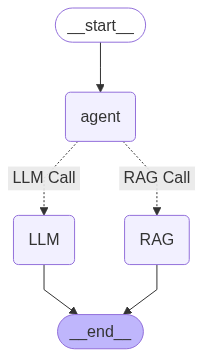

In [ ]:
from IPython.display import Image, display

try:
    display(Image(app5.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)

In [ ]:
state={"message": ["Tell me about India's Industrial Growth"]}
inputs = {"message": [ "Tell me about India's Industrial Growth"]}

In [ ]:
output = app5.invoke(inputs)
print(output)


Tell me about India's Industrial Growth
Not Related
Not Related
{'query': "Tell me about India's Industrial Growth", 'answer': 'India\'s industrial growth has seen significant progress over the years, with the country\'s industrial sector contributing significantly to its overall economic development. The Industrial sector in India includes various key industries such as manufacturing, mining, electricity, and construction.\n\nIndia has experienced steady industrial growth, thanks to various government initiatives aimed at promoting industrialization, such as the "Make in India" campaign. The country has also implemented various reforms to improve the ease of doing business, attract foreign investment, and boost manufacturing activities.\n\nThe industrial growth in India has been primarily driven by sectors such as automotive, textiles, pharmaceuticals, information technology, and telecommunications. India\'s industrial sector has also been benefiting from the increasing trend of outso